In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
def load_and_prepare_data(file_path):
    """Carga y prepara los datos iniciales"""
    df = pd.read_csv(file_path)
    
    # Convertir fecha a datetime
    df['fecha'] = pd.to_datetime(df['fecha'])
    
    # Crear variables derivadas adicionales
    df['deficit_real'] = df['demanda_maxima'] - df['disponibilidad_total']
    df['margen_seguridad'] = df['disponibilidad_total'] - df['demanda_maxima']
    df['eficiencia_07am'] = df['disponibilidad_07am'] / df['disponibilidad_total'] * 100
    df['utilizacion_07am'] = df['demanda_07am'] / df['disponibilidad_07am'] * 100
    
    # Categorizar días
    df['tipo_dia'] = df['dia_semana'].map({
        0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves',
        4: 'Viernes', 5: 'Sábado', 6: 'Domingo'
    })
    
    return df


file_path = '../data/processed/cleaned_energy_data.csv'
df = load_and_prepare_data(file_path)

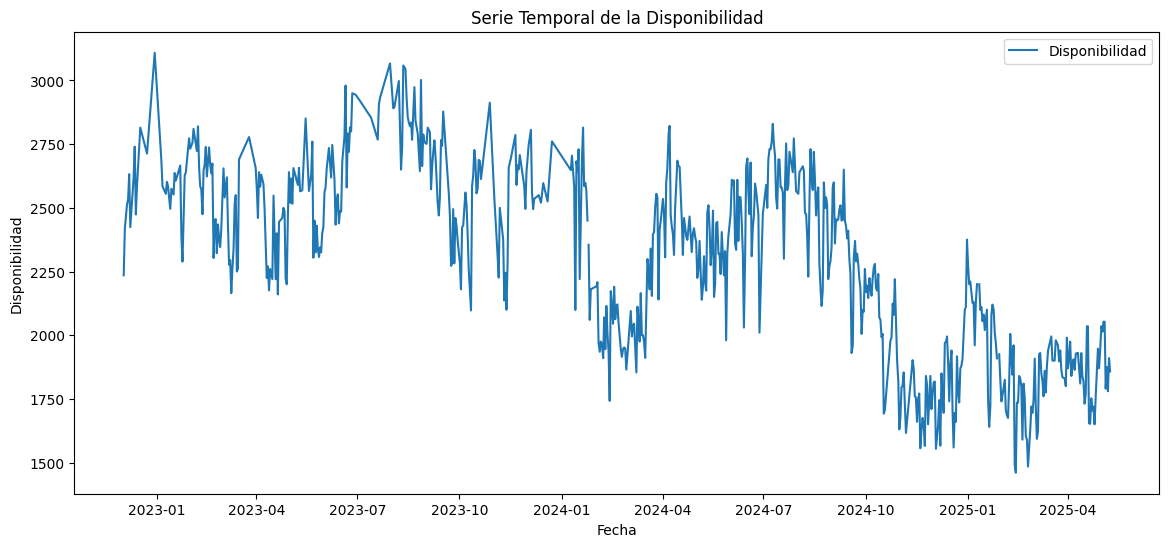

In [4]:
df = df.set_index('fecha').sort_index()

plt.figure(figsize=(14,6))
plt.plot(df['disponibilidad_total'], label='Disponibilidad')
plt.title('Serie Temporal de la Disponibilidad')
plt.xlabel('Fecha')
plt.ylabel('Disponibilidad')
plt.legend()
plt.show()


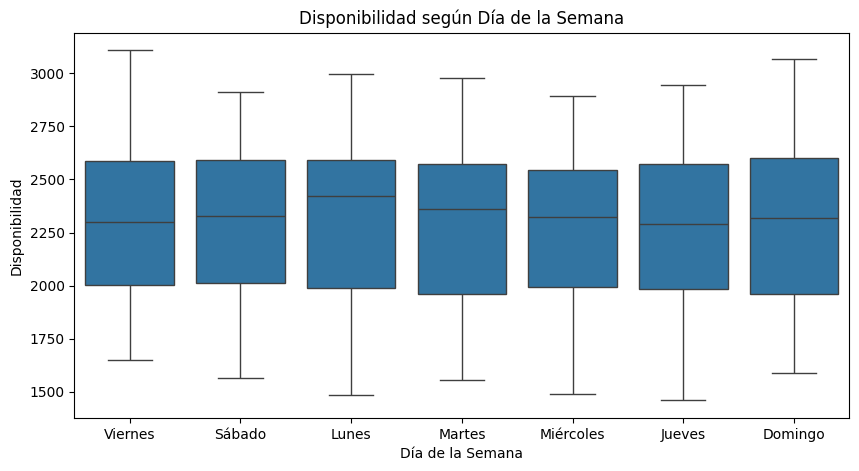

In [5]:
plt.figure(figsize=(10,5))
sns.boxplot(x='tipo_dia', y='disponibilidad_total', data=df.reset_index())
plt.title('Disponibilidad según Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Disponibilidad')
plt.show()


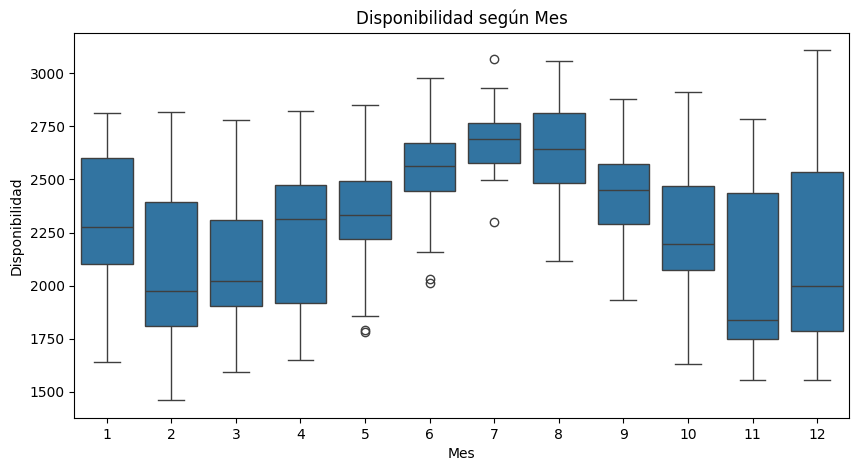

In [6]:
plt.figure(figsize=(10,5))
sns.boxplot(x='mes', y='disponibilidad_total', data=df.reset_index())
plt.title('Disponibilidad según Mes')
plt.xlabel('Mes')
plt.ylabel('Disponibilidad')
plt.show()


In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['disponibilidad_total'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
# Si p-value < 0.05, la serie es estacionaria


ADF Statistic: -1.7936680902827866
p-value: 0.3836098115775268


In [11]:
# Crear lags
for lag in range(1, 8):
    df[f'disponibilidad_total_lag{lag}'] = df['disponibilidad_total'].shift(lag)

features = [f'disponibilidad_total_lag{lag}' for lag in range(1, 8)] + [
    'disponibilidad_07am','mw_motores_problemas','mw_limitacion_termica','mes','plantas_averiadas','demanda_07am', 'dia_semana', 'es_fin_semana','demanda_maxima','plantas_mantenimiento','año'
]
df_ml = df.dropna(subset=features + ['disponibilidad_total'])

X = df_ml[features]
y = df_ml['disponibilidad_total']

# División temporal
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# GridSearchCV con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

pred_rf = grid_search.predict(X_test)

# Evaluar
mae_rf = mean_absolute_error(y_test, pred_rf)
mse_rf = mean_squared_error(y_test, pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, pred_rf)

print(f'MAE Random Forest: {mae_rf:.4f}')
print(f'MSE Random Forest: {mse_rf:.4f}')
print(f'RMSE Random Forest: {rmse_rf:.4f}')
print(f'R² Random Forest: {r2_rf:.4f}')


{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
MAE Random Forest: 107.9174
MSE Random Forest: 17058.0476
RMSE Random Forest: 130.6065
R² Random Forest: 0.4378
